In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Local Differential Privacy(LDP) with Bounded Laplace Mechanism(BLM)

## LDP
 The notion of LDP can be written as follows,
  $$\frac{Pr[A(v) == y ]}{Pr[A(\hat{v}) == y]}   <= \epsilon $$
An Algorithm $A$ satisfies an $\epsilon-Local~Differential~Privacy$ where $\epsilon > 0$ $if~and~only~if$ for any input $v$ and $\hat{v}$

## BLM
  BLM is the randomized mechanism that we will use for our privacy preserving mechanism. We will simulate LDP and see if this Mechanism satisfies $\epsilon$-LDP. Also, I will try to experiment the boundary or some constraints for this mechanism to work.

  The Bounded Laplace Mechanism is as follows,
  $$f_{W_q}(x) = \frac{1}{C_q}\frac{1}{2b}e^{-\frac{|x-q|}{b}}, ~~x \in D$$


In this notebook we will do the followings
 1. Build a metric that measures whether a mechanism satisfies Differential Privacy
 2. Define a BLM function and show it satisfies $\epsilon$-LDP



In [6]:
sensitivity=1
epsilon = 0.1

np.random.laplace(scale=sensitivity/epsilon)

-29.041246411382062

In [7]:
# laplace mechanism

def laplace_mechanism(value: float, sensitivity: float, epsilon: float):
    '''
    This function is the basic laplace mechanism
    '''
    if epsilon <= 0 :
        raise ValueError("epsilon should be bigger than 0")
    
    randomized_noise = np.random.laplace(scale=sensitivity/epsilon)
    value_hat = value + randomized_noise
    return value_hat

# check the results of laplace mechanism
laplace_mechanism(10, 0.1, 0.1)    

10.223644903609589

<AxesSubplot:>

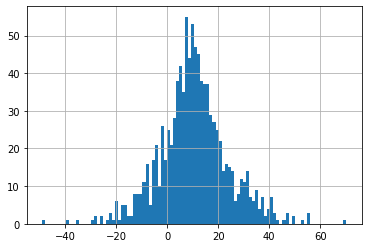

In [14]:
samples = pd.Series([laplace_mechanism(10, 1, 0.1) for _ in range(1000)])

samples.hist(bins=100)

# we can see that the values are created from laplace distribution
# some values are even negative, or too big than the original value
# we will implement bounded laplace mechism to solve these issues..

## Applying BLM

Lets say we wanted to take the value 4 and wanted to satisfy local differential privacy using BLM. We want the value to be in the range of 1 to 10. 
In this situation, how can we make apply BLM? Is it possible to apply this mechanism? Will it not violate privacy loss? 

There are some regulations that must be met in order to satisfy BLM.

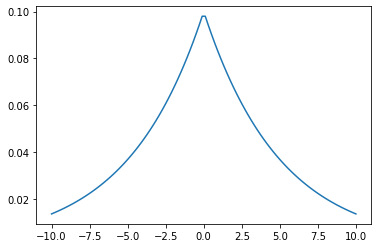

In [50]:
# here we can see the pdf of lpalace distribution

def pdf_laplace(x):
    q = 0
    b = 5
    return (1/(2*b))*np.exp(-abs(x-q)/b)

xs = np.linspace(-10,10,100)
v_pdf_laplace = np.vectorize(pdf_laplace)
plt.plot(xs, v_pdf_laplace(xs))

In [23]:
# compare the integrals of analytical calculation and asymptoc
import scipy.integrate as integrate

def f(x):
    b = 1
    mu = 10
    return (1/(2*b))*np.exp(-(abs(x- mu))/b)

analyticalAnswer, calAnswer = integrate.quad(f, 8, 12)

print('the difference between analytical calcuation and other is..')
print(analyticalAnswer - calAnswer)

the difference between analytical calcuation and other is..
0.8646647167633779


In [10]:
def cal_C(value, D, b):
    l, u = D
    return 1 - (1/2)*(np.exp((l-value)/b) + np.exp((value-u)/b))
cal_C(10, (8,12),1)

0.8646647167633873

In [28]:
def pdf_Wq(value, D: tuple, b, epsilon, delta): 
    '''
    density function of Wq(bounded laplace mechanism)
    D : the support for x(value)
    b : variance -> requires checkup. 
    sensitivity : the minimal difference 
    '''
    # assign boundaries
    l, u  = D

    if value not in range(l,u+1): return 0
    
    # Theorem 4.4(Fixed Point)
    dQ = abs(u - l)
    
    # calculate Cl, Cl_dQ #Definition3.4
    Cl = cal_C(l, D, b)
    Cl_dQ = cal_C(l + dQ, D, b)
    
    dC = Cl_dQ / Cl
    print(f'Cl is {Cl} and Cl_dQ is {Cl_dQ}')
    print(f'dC is {dC}')

    if b < dQ/(epsilon - np.log(dC) - np.log(1 - delta)) :
        print('the variance does not suffice the preconditions')
        print('editing b ...')
        b = dQ/(epsilon - np.log(dC) - np.log(1 - delta))
        print(f"the value of b is {b}")
        # update b

    # calculate the optimal Cq
    Cq = cal_C(value, D, b)
    print(f'the optimal Cq is {Cq}')
    # return density 
    theRange = np.linspace(l, u, num = 10**4)

    e_term = np.exp(-(abs(theRange - value)/b))
    density  = (1/Cq)*(1/(2*b))*(e_term)
    # sum_of_densities = density.sum()
    # probability_density = density/sum_of_densities
    return density

    # perturbed_value = np.random.choice(theRange, 1, p=density)
    # return perturbed_value
    

Cl is 0.5 and Cl_dQ is 0.5
dC is 1.0
the variance does not suffice the preconditions
editing b ...
the value of b is 19.486717352807474
the optimal Cq is 0.8632365816588334
Cl is 0.5 and Cl_dQ is 0.5
dC is 1.0
the variance does not suffice the preconditions
editing b ...
the value of b is 19.486717352807474
the optimal Cq is 0.8632365816588334
the sum is 124.9915639001095


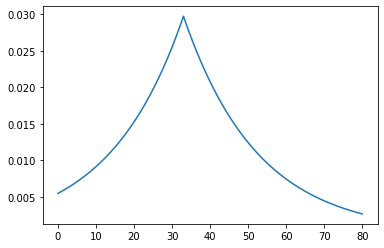

In [32]:
theRange = (0,80)
l,u = theRange
xs = np.linspace(l, u, num = 10**4)
plt.plot(xs, pdf_Wq(33, (0,80), 1, 4, 0.1))

probs = pdf_Wq(33, (0,80), 1, 4, 0.1)
print(f"the sum is {probs.sum()}")

In [ ]:
# solving problems for probability convergence issues
# the sum of the density should become 1 

pdf_Wq(33, (0,80), 1, 4, 0.1).sum()

Cl is 0.5 and Cl_dQ is 0.5
dC is 1.0
the variance does not suffice the preconditions
editing b ...
the value of b is 19.486717352807474
the optimal Cq is 0.8632365816588334


124.9915639001095

As we can see above, the sum of the probabilities are not converging to 1. 
The reason is the regularizing factor Cq is not working well. I think there are some differences occuring in analytical part and the implementation part.

So, we will normalize the probabilities by dividing it with the sum of the probabilities

In [50]:
# second prototype code for Bounded Laplace Mechanism

def pdf_Wq2(value, D: tuple, b, epsilon, delta): 
    '''
    density function of Wq(bounded laplace mechanism)
    D : the support for x(value)
    b : variance -> requires checkup. 
    sensitivity : the minimal difference 
    '''
    # assign boundaries
    l, u  = D

    if value not in range(l,u+1): return 0
    
    # Theorem 4.4(Fixed Point)
    dQ = abs(u - l)
    
    # calculate Cl, Cl_dQ #Definition3.4
    Cl = cal_C(l, D, b)
    Cl_dQ = cal_C(l + dQ, D, b)
    
    dC = Cl_dQ / Cl
    print(f'Cl is {Cl} and Cl_dQ is {Cl_dQ}')
    print(f'dC is {dC}')

    if b < dQ/(epsilon - np.log(dC) - np.log(1 - delta)) :
        print('the variance does not suffice the preconditions')
        print('editing b ...')
        b = dQ/(epsilon - np.log(dC) - np.log(1 - delta))
        print(f"the value of b is {b}")
        # update b

    # Here we do not calculate Cq 
    # Instead we calculate the function and then sum the output calculations
    theRange = np.linspace(l, u, num = 10**4)
    e_term = np.exp(-(abs(theRange - value)/b)) 
    output_calculation  = (1/(2*b))*(e_term)
    
    # sum the output calculation and normalize
    theSum = output_calculation.sum()
    density = output_calculation/theSum 

    return density

Cl is 0.5 and Cl_dQ is 0.5
dC is 1.0
the variance does not suffice the preconditions
editing b ...
the value of b is 19.486717352807474
Cl is 0.5 and Cl_dQ is 0.5
dC is 1.0
the variance does not suffice the preconditions
editing b ...
the value of b is 19.486717352807474
the sum is 0.9999999999999999


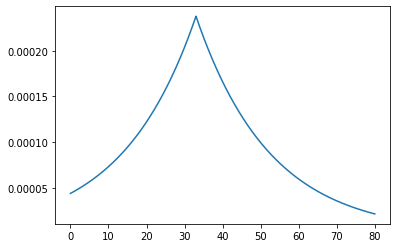

In [51]:
theRange = (0,80)
l,u = theRange
xs = np.linspace(l, u, num = 10**4)
plt.plot(xs, pdf_Wq2(33, (0,80), 1, 4, 0.1))

probs = pdf_Wq2(33, (0,80), 1, 4, 0.1)
print(f"the sum is {probs.sum()}")

Now we can see that the probabilities are converging to 1. Now our code for BLM is ready to go.

## Modify to output randomized values
Now lets modify the code to pick a random value 

In [70]:
# second prototype code for Bounded Laplace Mechanism.
# we will make this code to produce modified continuous values

def BLM(value, D: tuple, b, epsilon, delta): 
    '''
    density function of Wq(bounded laplace mechanism)
    D : the support for x(value)
    b : variance -> requires checkup. 
    sensitivity : the minimal difference 
    '''
    # assign boundaries
    l, u  = D

    if value not in range(l,u+1): return 0
    
    # Theorem 4.4(Fixed Point)
    dQ = abs(u - l)
    
    # calculate Cl, Cl_dQ #Definition3.4
    Cl = cal_C(l, D, b)
    Cl_dQ = cal_C(l + dQ, D, b)
    
    dC = Cl_dQ / Cl
    # print(f'Cl is {Cl} and Cl_dQ is {Cl_dQ}')
    # print(f'dC is {dC}')

    if b < dQ/(epsilon - np.log(dC) - np.log(1 - delta)) :
        # print('the variance does not suffice the preconditions')
        # print('editing b ...')
        b = dQ/(epsilon - np.log(dC) - np.log(1 - delta))
        # print(f"the value of b is {b}")
        # update b

    # Here we do not calculate Cq 
    # Instead we calculate the function and then sum the output calculations
    theRange = np.linspace(l, u, num = 10**4)
    e_term = np.exp(-(abs(theRange - value)/b)) 
    output_calculation  = (1/(2*b))*(e_term)
    
    # sum the output calculation and normalize
    theSum = output_calculation.sum()
    density = output_calculation/theSum 
    
    # the function will output a randomized output!
    randomized_output = np.random.choice(theRange, 1, p=density)

    return randomized_output.item()

### Simulation
- we want the number to be between 0 and 9.
- The true value will be 7

In [69]:
# simulation

[BLM(7, (0,9), 1, 0.1, 0.1) for _ in range(0,10)]
# the values are being produced!!

[6.864086408640864,
 0.2646264626462646,
 6.799279927992799,
 3.888388838883888,
 3.8640864086408637,
 2.675967596759676,
 1.4518451845184517,
 4.382538253825382,
 6.434743474347434,
 8.306030603060305]